In [166]:
from utils import up_sample_wav_12_to_48
from IPython.display import Audio
import librosa

from models.AudioUNet import AudioUNet
import torch
from scipy import interpolate
from scipy.signal import decimate
import numpy as np

In [167]:
def spline_up(x_lr, r):
  x_lr = x_lr.flatten()
  x_hr_len = len(x_lr) * r
  x_sp = np.zeros(x_hr_len)

  i_lr = np.arange(x_hr_len, step=r)
  i_hr = np.arange(x_hr_len)

  f = interpolate.splrep(i_lr, x_lr)
  x_sp = interpolate.splev(i_hr, f)

  return x_sp
def up_sample_wav_12_to_48(
      test_audio_path,
      ckpt,
      in_sr = 48000,
      r = 4,
      ):
    '''
    read audio, normalized to -1 and 1 and crop the audio sample points to multiple of args.patch_size
    '''
    # check device if CPU or GPU
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # load model and hyper parameters
    checkpoint = torch.load(ckpt)
    model = AudioUNet().to(device)
    num_blocks = 4
    patch_size = checkpoint['patch_size']
    model.load_state_dict(checkpoint['model_state_dict'])
    model.to(device)

    # preprocess the low resolution audio to be multiple of model patch_size
    audio_hr, _ = librosa.load(test_audio_path, sr = in_sr)
    #print(audio_lr.shape)
    audio_hr  = np.pad(audio_hr, (0, patch_size - (audio_hr.shape[0] % patch_size)), 'constant', constant_values=(0,0))
    #print(audio_lr.shape)
    audio_lr = decimate(audio_hr, 4)  
    
    # normalize the amplitude to -1 and 1 and reshape to (1, 1, len(audio))
    # x_scale = np.max(np.abs(audio_lr))
    # audio_lr = audio_lr / x_scale
    audio_lr = audio_lr.reshape((1, 1, len(audio_lr)))
    print(audio_lr.shape)
    #preprocessing
    assert len(audio_lr) == 1
    x_sp = spline_up(audio_lr, r)
    x_sp = x_sp[: len(x_sp) - (len(x_sp) % (2**(num_blocks+1)))]
    x_sp = x_sp.reshape((1 , 1, len(x_sp)))
    # reshape to (batch, 1, 1892) and change to tensor
    x_sp = x_sp.reshape((int(x_sp.shape[2]/patch_size), 1, patch_size))
    x_sp = torch.Tensor(x_sp).cuda()
    #print(x_sp.shape)

    model.eval()
    with torch.no_grad():
      predict_hr = model(x_sp)
    #print(predict_hr.shape)
    predict_hr = predict_hr.flatten()
    predict_hr = predict_hr.detach().cpu().numpy()
    #print(predict_hr.shape)
    
    return predict_hr

In [168]:
ckpt_path = './ckpts/EXP_SINGLE.pth'
wav12 = './data/test/test/16k/p225/p225_064.wav'
wav48 = './data/test/test/48k/p225/p225_064.wav'
predict_audio = up_sample_wav_12_to_48(wav48, ckpt_path)

(1, 1, 22528)


In [169]:
predict_audio.shape

(90112,)

In [170]:
wave_lr, r = librosa.load(wav12, sr = 12000)
print(wave_lr.shape)
wave_hr, r = librosa.load(wav48, sr = 48000)
print(wave_hr.shape)

(21639,)
(86556,)


In [171]:
Audio(wav12)

In [172]:
Audio(wav48)

In [173]:
Audio(predict_audio, rate = 48000)

In [174]:
from scipy import interpolate
import numpy as np
def PSNR(one_predict_hr, one_gt_hr):
    mse = np.mean((np.array(one_gt_hr, dtype=np.float32) - np.array(one_predict_hr, dtype=np.float32)) ** 2)
    return 20 * np.log10(np.max(one_gt_hr) / (np.sqrt(mse)))

def upsample(x_lr, r):
    x_lr = x_lr.flatten()
    x_hr_len = len(x_lr) * r
    x_sp = np.zeros(x_hr_len)

    i_lr = np.arange(x_hr_len, step=r)
    i_hr = np.arange(x_hr_len)

    f = interpolate.splrep(i_lr, x_lr)
    x_sp = interpolate.splev(i_hr, f)

    return x_sp
def LSD(one_predict_hr, one_gt_hr):
    spectrogram1 = np.abs(librosa.stft(one_predict_hr))
    spectrogram2 = np.abs(librosa.stft(one_gt_hr))
    spectrogram_log1 = np.log10(spectrogram1 ** 2)
    spectrogram_log2 = np.log10(spectrogram2 ** 2)
    original_target_squared = (spectrogram_log1 - spectrogram_log2) ** 2
    log_spectral_distance = np.mean(np.sqrt(np.mean(original_target_squared, axis = 0)))
    return log_spectral_distance

def SNR(one_predict_hr, one_gt_hr):
    signal = np.sum(one_predict_hr**2)
    noise = np.sum((one_predict_hr - one_gt_hr) ** 2)
    snr = 10 * np.log10(signal / noise)
    return snr

In [175]:
pa = predict_audio[:len(wave_hr)]
print('Predicted PSNR:',PSNR(pa, wave_hr))
print('Predicted SNR:',SNR(pa, wave_hr))
print('Predicted LSD',LSD(pa, wave_hr))

Predicted PSNR: 36.74052715301514
Predicted SNR: 18.60857367515564
Predicted LSD 2.297259


In [176]:
wave_lr = upsample(wave_lr, 4)
wave_lr = wave_lr[:len(wave_hr)]
print('Predicted PSNR:',PSNR(wave_lr, wave_hr))
print('Predicted SNR:',SNR(wave_lr, wave_hr))
print('Predicted LSD',LSD(wave_lr, wave_hr))

Predicted PSNR: 37.060396671295166
Predicted SNR: 18.961923358726384
Predicted LSD 5.007483878934212


In [177]:
import matplotlib.pyplot as plt
%matplotlib inline
def get_spectrum(data, n_fft=2048):
    data=data[0:len(data)-len(data)%n_fft]
    S = librosa.stft(data, n_fft=2048)
    S = np.log1p(np.abs(S))
    return S

def plot_train_and_gt_spectrum(train, gt):
    assert train.shape == gt.shape
    train_spectrum = get_spectrum(train)
    gt_spectrum = get_spectrum(gt)
    fig, axes = plt.subplots(nrows=1, ncols=2)
    fig.tight_layout()
    axes[0].imshow(train_spectrum.T, aspect = 10)
    axes[0].set_title(f'Predicted spectrogram')
    axes[1].imshow(gt_spectrum.T, aspect = 10)
    axes[1].set_title(f'Ground truth spectrogram')
    plt.show()

Text(0.5, 1.0, 'Ground truth spectrogram')

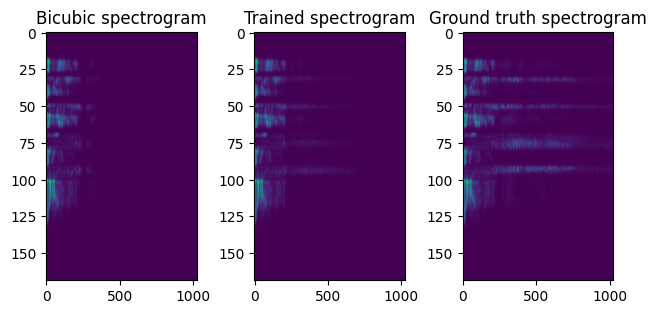

In [178]:
cubic_spectrum = get_spectrum(wave_lr)
gt_spectrum = get_spectrum(wave_hr)
train_spectrum = get_spectrum(pa)
fig, axes = plt.subplots(nrows=1, ncols=3)
fig.tight_layout()
axes[0].imshow(cubic_spectrum.T, aspect = 10)
axes[0].set_title(f'Bicubic spectrogram')
axes[1].imshow(train_spectrum.T, aspect = 10)
axes[1].set_title(f'Trained spectrogram')
axes[2].imshow(gt_spectrum.T, aspect = 10)
axes[2].set_title(f'Ground truth spectrogram')